#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 05
**CH05A What Likelihood of Loss to Expect on a Stock Portfolio?**

using the sp500 dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import seaborn as sns
from matplotlib.ticker import PercentFormatter, ScalarFormatter
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
import py_helper_functions as da
sns.set_theme(rc=da.da_theme, palette=da.color)

In [4]:
sp500 = pd.read_csv(data_in + "SP500_2006_16_data.csv")
# sp500 = pd.read_csv("https://osf.io/h64z2/download")


In [5]:
sp500 = sp500.replace("", np.nan).replace("#N/A", np.nan).dropna().reset_index(drop=True)

Create percent return

In [6]:
sp500["pct_return"] = sp500["VALUE"].pct_change() * 100

Create date variables (we dont use these though)

In [7]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].dt.year
sp500["month"] = sp500["DATE"].dt.month
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]

### Figure 5.1 Histogram of daily returns in the entire data

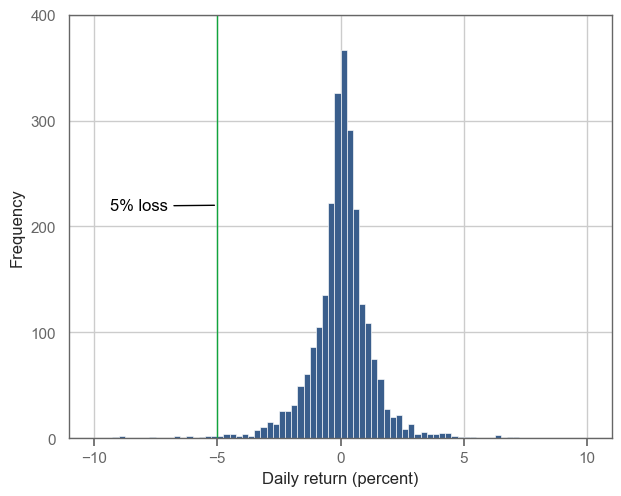

In [8]:
sns.histplot(
    data=sp500,
    x="pct_return",
    binwidth=0.25,
    binrange=(-10,10),
    fill=True,
    color=da.color[0],
    alpha = 1
)


plt.axvline(x=-5, color=da.color[1], linewidth=1, linestyle='-')
plt.annotate(
    "5% loss",
    xy=(-5, 220), 
    xytext=(-7, 215), 
    fontsize=12,
    ha="right",
    arrowprops=dict(arrowstyle="-", color="black"),
)




plt.xlabel("Daily return (percent)")
plt.ylabel("Frequency")
plt.xlim(-11, 11)
plt.xticks(ticks=np.arange(-10, 11, 5))  
plt.ylim(0, 400)
plt.yticks(ticks=np.arange(0, 401, 100))  
plt.show()

### Figure 5.2 prep

 Create 10 000 samples, with 500 and 1000 observations in each sample, taken from sp500["pct_return"]

In every sample: for each observation, check if it is a loss of 5% or more. Then calculate the percentage of observations out of 500 or 1000 where the loss exceeds 5%. 

In [9]:
# help(create_sample_frame)

In [10]:
nobs_1000 = np.mean(
    da.create_sample_frame(sp500["pct_return"], 1000, with_replacement=False) < -5,
    axis=1,
)
nobs_500 = np.mean(
    da.create_sample_frame(sp500["pct_return"], 500, with_replacement=False) < -5,
    axis=1,
)

In [11]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000}) * 100

In [12]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


### Figure 5.2

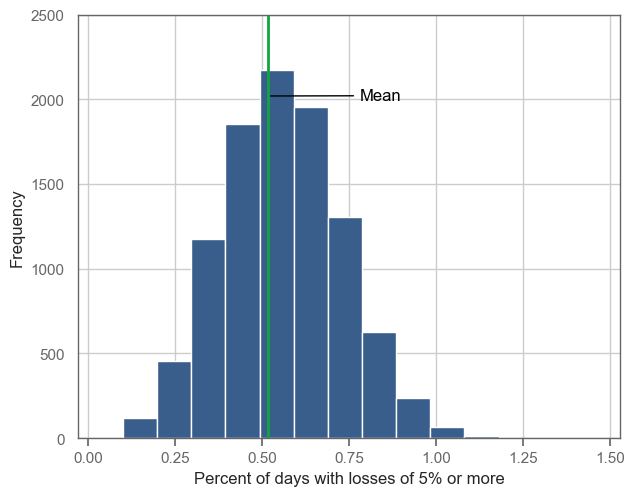

In [13]:
sns.histplot(
    data=nobs_df,
    x="nobs_1000",
    binwidth=0.1,
    binrange=(0.1,1.18),
    fill=True,
    color=da.color[0],
    alpha = 1
)


plt.axvline(x=nobs_df["nobs_1000"].mean(), color=da.color[1], linewidth=2, linestyle='-')
plt.annotate(
    "Mean",
    xy=(nobs_df["nobs_1000"].mean(), 2020), 
    xytext=(0.9, 1995), 
    fontsize=12,
    ha="right",
    arrowprops=dict(arrowstyle="-", color="black"),
)




plt.xlabel("Percent of days with losses of 5% or more")
plt.ylabel("Frequency")
plt.xlim(-0.03, 1.53)
plt.xticks(ticks=np.arange(0, 1.53, 0.25))  
plt.ylim(0, 2500)
plt.yticks(ticks=np.arange(0, 2501, 500))  
plt.show()

### Figure 5.3 

Not working with epanechnikov kernel

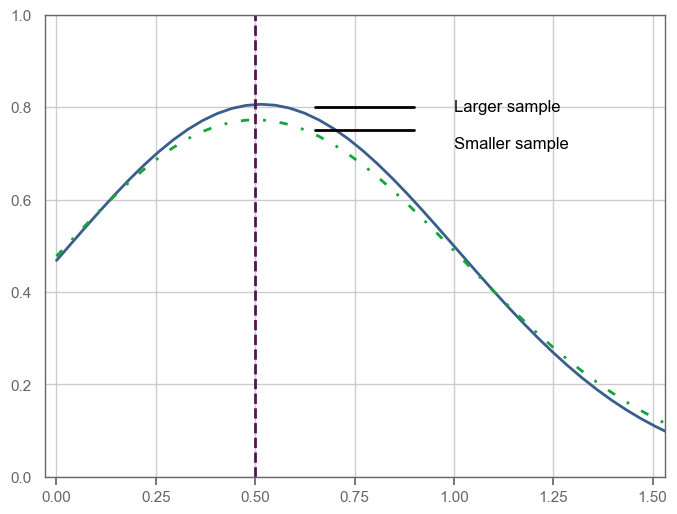

In [14]:

fig, ax = plt.subplots(figsize=(8, 6))

kde_1000 = gaussian_kde(nobs_df["nobs_1000"], bw_method=2.6)
x_vals = np.linspace(0, 1.8)
sns.lineplot(
    x=x_vals,
    y=kde_1000(x_vals),
    color=da.color[0],
    linewidth=2,
    ax=ax
)


x_vals = np.linspace(0, 1.8)
kde_500 = gaussian_kde(nobs_df["nobs_500"],bw_method=1.5)
sns.lineplot(
    x=x_vals,
    y=kde_500(x_vals),
    color=da.color[1],
    linestyle=(0, (3, 5, 1, 5)),  
    linewidth=2,
    ax=ax
)
ax.axvline(x=0.5, color=da.color[2], linewidth=2, linestyle="dashed")

ax.plot([0.9, 0.65], [0.8, 0.8], color="black", linewidth=2)  
ax.plot([0.9, 0.65], [0.75, 0.75], color="black", linewidth=2)  

ax.text(1, 0.8, "Larger sample", fontsize=12, verticalalignment='center')
ax.text(1, 0.72, "Smaller sample", fontsize=12, verticalalignment='center')
ax.set_xlim(-0.03, 1.53)
ax.set_xticks(np.arange(0, 1.51, 0.25))

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.2))

plt.show()

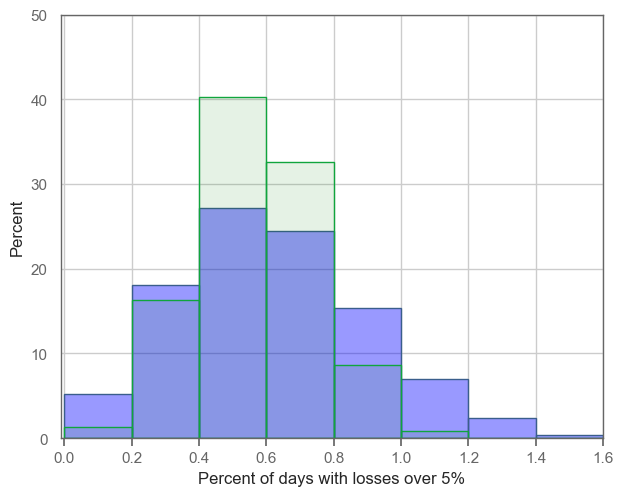

In [15]:
fig, ax = plt.subplots()
sns.histplot(
    nobs_df["nobs_500"],
    binwidth=0.2,
    binrange=(0,1.59999),  
    stat="percent",  
    color="blue",
    edgecolor=da.color[0],
    alpha=0.4,
    linewidth=1,
    ax=ax,
    label="N = 500",
)

sns.histplot(
    nobs_df["nobs_1000"],
    binwidth=0.2,
    binrange=(0,1.59999), 
    stat="percent",
    color="green",
    edgecolor=da.color[1],
    alpha=0.1,
    linewidth=1,
    ax=ax,
    label="N = 1000",
)

ax.set_xlabel("Percent of days with losses over 5%", fontsize=12)
ax.set_ylabel("Percent", fontsize=12)
ax.set_xlim(-0.01, 1.6)
ax.set_ylim(0, 50) 
ax.set_xticks(np.arange(0, 1.61, 0.2))
plt.show()

Create bootstrap samples

In [16]:
bootstrap_samples = da.create_sample_frame(
    sp500["pct_return"], len(sp500["pct_return"]), with_replacement=True
)

Calculate percent of days wit losses over  thresholds from -1 to 10

In [17]:
bootstrap_loss_results = pd.DataFrame(
    [
        np.mean(bootstrap_samples < -1 * pct_loss, axis=1) * 100
        for pct_loss in range(1, 11)
    ],
    index=[f"loss{i}" for i in range(1, 11)],
).T

Plot percent of days with losses over -5%

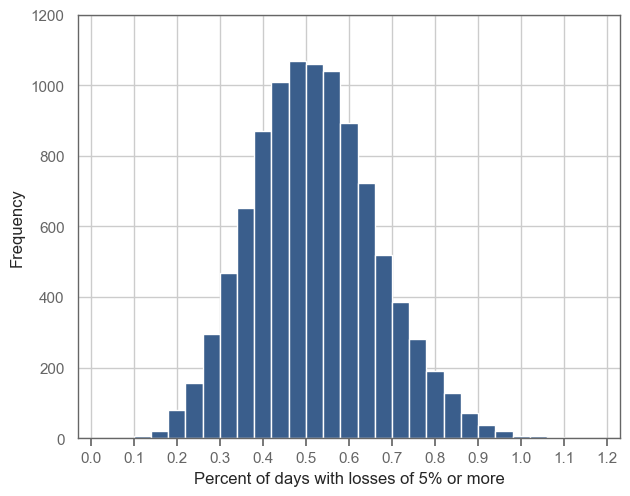

<Figure size 1000x600 with 0 Axes>

In [18]:
sns.histplot(
    data=bootstrap_loss_results,
    x="loss5",
    binwidth=0.04,
    binrange=(0.1,1.18),
    fill=True,
    color=da.color[0],
    alpha = 1
)





plt.xlabel("Percent of days with losses of 5% or more")
plt.ylabel("Frequency")
plt.xlim(-0.03, 1.23)
plt.xticks(ticks=np.arange(0, 1.23, 0.1))  
plt.ylim(0, 1200)
plt.yticks(ticks=np.arange(0, 1201, 200))  
plt.figure(figsize=(10,6))
plt.show()